# Data exploration

Now that we have extracted our features, we can start the project by doing some quick explorations on the data.

## 1. Plot a few images from each category

In [1]:
import os

# Create a function that extract list names of each folder without hidden files
def listdir_nohidden(path):
    list = []
    for f in os.listdir(path):
        if not f.startswith('.'): # remove hidden files
            list.append(f)
    return list
  
# List the different categories
category_names = listdir_nohidden('swissroads/train')
category_names

['car', 'bike', 'other', 'van', 'motorcycle', 'truck']

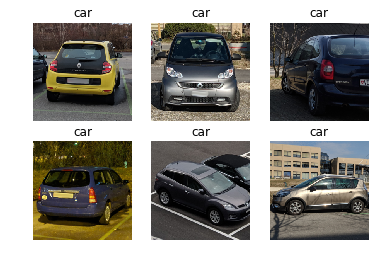

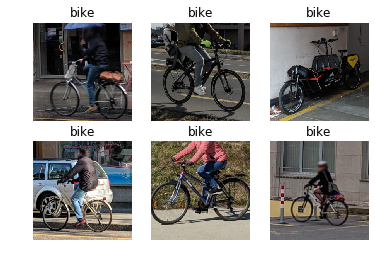

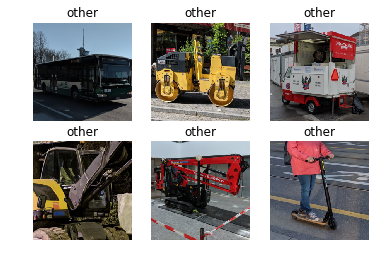

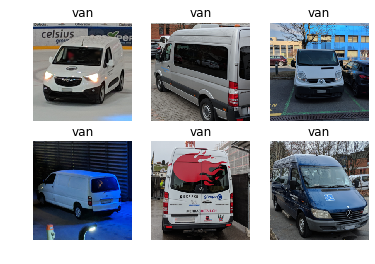

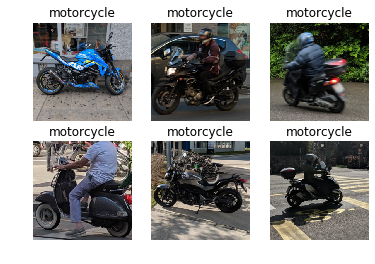

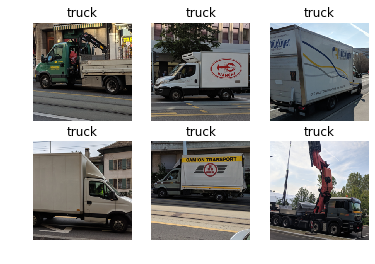

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image

# Print 6 images from each category
for each in category_names:
    plt.figure()
    currentFolder = "swissroads/train/" + each # create the path of each subfolderb
    for i, file in enumerate(os.listdir(currentFolder)[0:6]):
        fullpath = currentFolder + "/" + file
        img = Image.open(fullpath)
        plt.subplot(2, 3, i+1)
        plt.axis('off')
        plt.title(each)
        plt.imshow(img)

We see that the images are quite similar (van vs truck and motorcycle vs bike). This is also real data, in the sense that the pictures were taken at Lausanne EPFL with a real camera in different positions and have not been modified. I'm looking forward to see what our classifiers can do.

Before training models, let's do a little exploration using the Principal Component Analysis (PCA) which is a linear dimensionality reduction technique (algorithm) that transform a set of correlated variables (p) into a smaller k (k<p) number of uncorrelated variables called __principal components__ while keeping as much of the variability in the original data as possible. To do this, we will take our high-level features that have been pre-trained previously by the [Inception v3](https://tfhub.dev/google/imagenet/inception_v3/classification/5) model.

Before moving with the scree plot, we first need to load the high-level features that we extracted in the first notebook.

In [3]:
import numpy as np

# Import the data
# Load the numpy .npz file
with np.load(os.path.join('processed_data', 'features_tr.npz'), allow_pickle=False) as data:
    features = dict(data.items())

print('It is a dictionary with keys:', list(features.keys()))

# Create X/y arrays
X_tr = features['x']
y_tr = features['y']

It is a dictionary with keys: ['x', 'y']


## 2. Scree plot of PCA

First, we apply with the original number of images (i.e., 280) since with PCA, the maximum components is the minimum between the number of dimensions and the number of rows, and create the scree plot to see how well PCA captures the variance of the data.

> __Note__: The number of components can not be more than ```min(n_samples, n_features)```. Mathematically speaking, the components are obtained by computing the eigenvectors and eigenvalues of the data covariance matrix $XX^{T}$ (usually by running the SVD algorithm). The covariance matrix has n_features eigenvalues. If n_samples < n_features as in this case, the covariance matrix will only have n_samples non-zero eigenvalues while the other ones will be null. Therefore, there will be only n_samples components that make sense in this case.



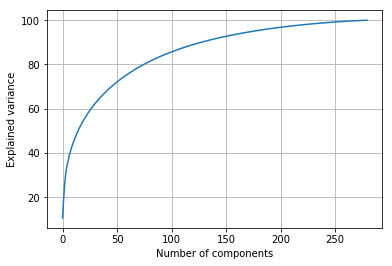

In [4]:
from sklearn.decomposition import PCA

# Create PCA transformer
pca280 = PCA(n_components=280)

# Apply PCA to rescaled data
pca280.fit(X_tr)

plt.grid()
plt.plot(np.cumsum(pca280.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance');

We can explain 95% of the variance with only 175 components. Let's try to see how much variance is explained with the first 10 components.

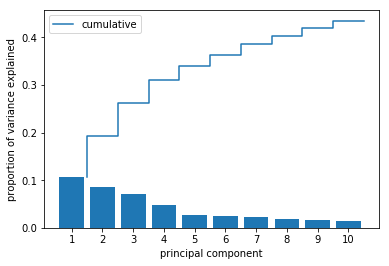

In [5]:
# Create PCA transformer
pca10 = PCA(n_components=10)

# Apply PCA to rescaled data
pca10.fit(X_tr)

# Proportion of variance explained
pve = pca10.explained_variance_ratio_

# Create bar plot
xcor = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, # 1.5,2.5,..,n_components+0.5
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Add labels
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')
plt.legend()
plt.show()

With the first 10 components, we reach a litle bit more than 40% of variance explained. Let's see the proportion with the first 50 components

In [9]:
# Proportion of variance explained of the first 50 components
pve280 = pca280.explained_variance_ratio_
sum(pve280[0:50])

0.7174238720908761

In [7]:
import pandas as pd
data = {'Number of components': [1, 2, 4, 8, 16, 27, 50, 75, 130, 280], 
        'Proportion of variance explained': ['10%', '20%', '30%' ,'40%','50%', '60%', '70%', '80%', '90%', '100%']}
prop_var = pd.DataFrame(data)
prop_var

,Number of components,Proportion of variance explained
0,1,10%
1,2,20%
2,4,30%
3,8,40%
4,16,50%
5,27,60%
6,50,70%
7,75,80%
8,130,90%
9,280,100%


PCA is one way to perform dimensionality reduction. Here we see that we can explain more than 90% of the variance with only 130 components instead of the 2048 original dimensions. Let's now try to visualize the features on a 2d-plot with PCA using the first two components.

## 3. 2d-plot features visualization with PCA

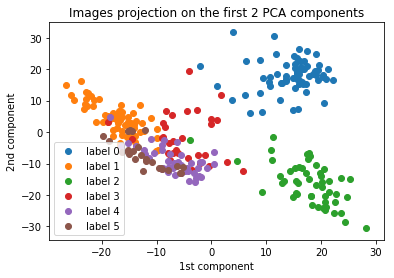

In [11]:
# Create PCA transformer
pca2 = PCA(n_components=2)

# Apply PCA to rescaled data
X_2d= pca2.fit_transform(X_tr)

# Plot each kind of category
for kind in [0,1, 2, 3, 4, 5]:
    # Wine samples of this type
    idx = (y_tr == kind)

    # Plot their components
    plt.scatter(
        X_2d[idx, 0], X_2d[idx, 1],
        label='label {}'.format(kind)
    )

# Labels and legend
plt.legend()
plt.title("Images projection on the first 2 PCA components")
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

It's interesting to note that PCA seems to be able to distinguish the images with labels 0 and 2 which are bikes and motorcycle with only the first two components. The rest seems a bit harder to tell and would require more components. That's amazing, I never thought he could tell bikes from motorcycles so easily. I think it's the fact that we often see people on these vehicles. This first component could actually detect people in the images. Of course this is just a guess.